In [31]:
import os
from comet_ml.api import API

comet_api = API(os.environ["COMETML_API_KEY"])


In [32]:
exps = {
    "peteish32": comet_api.get_experiments("ai2", "peteish32", "peteish32$"),
    "peteish13": comet_api.get_experiments("ai2", "olmo-2-1124-13b", "OLMo-2-1124-13B-stage-1"),
    "peteish7": comet_api.get_experiments("ai2", "olmo-core-7b", "peteish7")
}

print(repr({k: len(v) for k, v in exps.items()}))

{'peteish32': 61, 'peteish13': 75, 'peteish7': 13}


In [33]:
# print available metrics

for name, es in exps.items():
    metrics = set()
    for exp in es:
        for summary in exp.get_metrics_summary():
            metrics.add(summary["name"])
    metrics = list(metrics)
    metrics.sort()

    print(f"{name}:")
    for metric in metrics:
        print("\t", metric)

peteish32:
	 data/sequence length
	 eval/downstream/arc_challenge (BPB)
	 eval/downstream/arc_challenge (CE loss)
	 eval/downstream/arc_challenge (length-normalized accuracy)
	 eval/downstream/arc_challenge (log soft loss)
	 eval/downstream/arc_challenge (soft loss)
	 eval/downstream/arc_challenge_rc_5shot (BPB)
	 eval/downstream/arc_challenge_rc_5shot (CE loss)
	 eval/downstream/arc_challenge_rc_5shot (length-normalized accuracy)
	 eval/downstream/arc_challenge_rc_5shot (log soft loss)
	 eval/downstream/arc_challenge_rc_5shot (soft loss)
	 eval/downstream/arc_challenge_test_mc_5shot (BPB)
	 eval/downstream/arc_challenge_test_mc_5shot (CE loss)
	 eval/downstream/arc_challenge_test_mc_5shot (accuracy)
	 eval/downstream/arc_challenge_test_mc_5shot (log soft loss)
	 eval/downstream/arc_challenge_test_mc_5shot (soft loss)
	 eval/downstream/arc_challenge_test_rc_5shot (BPB)
	 eval/downstream/arc_challenge_test_rc_5shot (CE loss)
	 eval/downstream/arc_challenge_test_rc_5shot (length-normaliz

In [34]:
from tqdm.notebook import tqdm

def download_metric(exps, metric_name):
    result = {}
    for exp in tqdm(exps):
        metrics = exp.get_metrics(metric_name)
        for values in metrics:
            result[values['step']] = float(values['metricValue'])
    result = dict(sorted(result.items()))
    return result

loss = {
    name: download_metric(es, "train/CE loss")
    for name, es in exps.items()
}

skipped_steps = {
    name: download_metric(es, "optim/step skipped")
    for name, es in exps.items()
}

c4loss = {
    name: download_metric(es, "eval/lm/c4_en-validation/CE loss")
    for name, es in exps.items()
}

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

## Training Loss

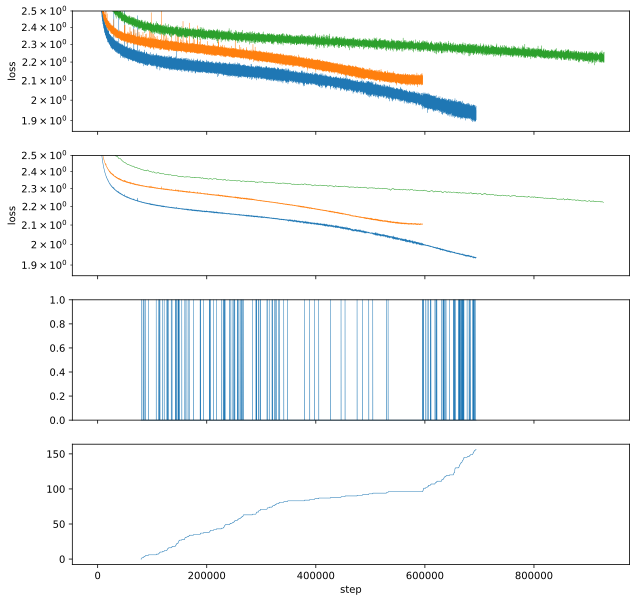

Steps skipped for the 32B: 156
[80788, 81072, 84048, 85129, 87386, 92844, 107316, 111491, 113030, 114230, 118668, 121925, 126863, 127493, 128136, 129747, 134843, 136385, 142362, 142815, 144303, 144548, 147139, 147455, 148216, 148703, 150206, 154267, 159678, 159881, 160407, 163682, 167141, 167784, 175621, 187888, 188783, 194308, 204820, 205830, 206617, 212691, 217589, 226667, 230116, 231534, 232070, 232547, 233702, 241716, 242968, 246500, 249425, 250814, 251497, 256147, 257243, 259138, 262122, 263662, 264763, 266531, 267012, 283650, 290117, 290727, 291531, 294977, 295352, 297826, 298508, 310444, 311075, 314537, 319684, 320934, 323994, 325632, 327859, 332049, 333763, 341230, 348251, 379042, 388815, 397842, 405374, 427126, 446246, 453587, 475639, 485607, 497096, 504446, 529565, 532519, 595613, 596523, 596811, 597430, 597533, 601508, 604050, 606109, 606289, 609893, 611068, 618383, 618985, 620914, 622022, 630579, 630729, 633063, 634102, 634913, 635236, 636978, 638788, 644973, 652349, 652575

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np

fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(10, 10))

MAX_STEP = 500000

# loss
for name, values in loss.items():
    xs = np.array(list(values.keys()))
    ys = np.array(list(values.values()))
    axs[0].semilogy(xs, ys, linewidth=0.5)
axs[0].set_ylim(1.85, 2.5)
#axs[0].set_xlim(0, MAX_STEP)
axs[0].set_ylabel("loss")

# loss smoothed
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
AVERAGE_WIDTH = 100
for name, values in loss.items():
    xs = np.array(list(values.keys()))
    ys = np.array(list(values.values()))
    xnew = np.linspace(xs[0], xs[-1], num=len(xs))
    ynew = np.interp(xnew, xs, ys)
    ynew = moving_average(ynew, AVERAGE_WIDTH)
    xnew = xnew[AVERAGE_WIDTH // 2:]
    xnew = xnew[:len(ynew)]
    assert len(xnew) == len(ynew)
    axs[1].semilogy(xnew, ynew, linewidth=0.5)
axs[1].set_ylim(1.85, 2.5)
#axs[1].set_xlim(0, MAX_STEP)
axs[1].set_ylabel("loss")

# steps skipped
for name, values in skipped_steps.items():
    xs = np.array(list(values.keys()))
    ys = np.array(list(values.values()))
    axs[2].plot(xs, ys, linewidth=0.5)
axs[2].set_ylim(0, 1)
#axs[2].set_xlim(0, MAX_STEP)

# steps skipped cumulative
for name, values in skipped_steps.items():
    xs = np.array(list(values.keys()))
    ys = np.array(list(values.values()))
    ys = ys.cumsum()
    axs[3].plot(xs, ys, linewidth=0.5)
#axs[3].set_ylim(0, 1)
#axs[3].set_xlim(0, MAX_STEP)

plt.xlabel("step")
plt.show()

print(f"Steps skipped for the 32B: {int(sum(skipped_steps['peteish32'].values()))}")
print([step for step, value in skipped_steps['peteish32'].items() if value > 0])

## Downstream

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

peteish32 / MMLU 5-shot MC max: 0.7093300508856772


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

peteish13 / MMLU 5-shot MC max: 0.6412677922248841


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Missing steps for peteish32 / Average of core 12: {5000, 3000, 4000}
peteish32 / Average of core 12 max: 0.7504962806900342


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

peteish13 / Average of core 12 max: 0.7487747346361479


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

peteish32 / Hellswag max: 0.8145787715911865


  0%|          | 0/75 [00:00<?, ?it/s]

peteish13 / Hellswag max: 0.812089204788208


  0%|          | 0/13 [00:00<?, ?it/s]

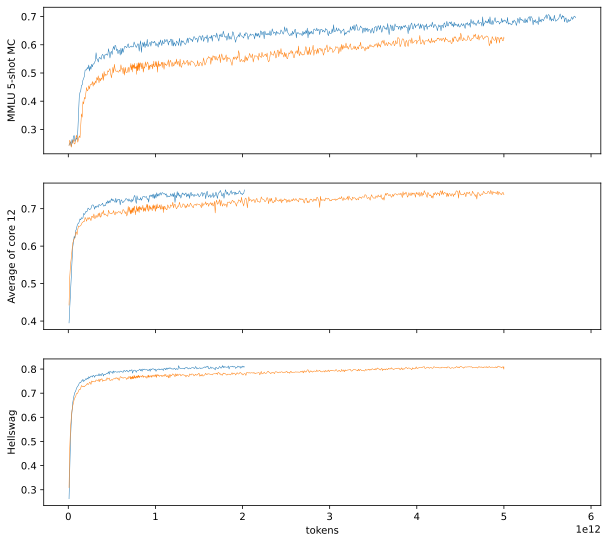

In [36]:
aggregate_metric_definitions = {
    "MMLU 5-shot MC": {
        "eval/downstream/mmlu_stem_mc_5shot (length-normalized accuracy)": 0.215,
        "eval/downstream/mmlu_humanities_mc_5shot (length-normalized accuracy)": 0.335,
        "eval/downstream/mmlu_social_sciences_mc_5shot (length-normalized accuracy)": 0.219,
        "eval/downstream/mmlu_other_mc_5shot (length-normalized accuracy)": 0.231
    },
    "Average of core 12": {
        "eval/downstream/arc_challenge (length-normalized accuracy)": 1 / 12,
        "eval/downstream/arc_easy (accuracy)": 1 / 12,
        "eval/downstream/basic_arithmetic (accuracy)": 1 / 12,
        "eval/downstream/boolq (accuracy)": 1 / 12,
        "eval/downstream/commonsense_qa (length-normalized accuracy)": 1 / 12,
        "eval/downstream/copa (accuracy)": 1 / 12,
        "eval/downstream/hellaswag (length-normalized accuracy)": 1 / 12,
        "eval/downstream/openbook_qa (length-normalized accuracy)": 1 / 12,
        "eval/downstream/piqa (length-normalized accuracy)": 1 / 12,
        "eval/downstream/sciq (accuracy)": 1 / 12,
        "eval/downstream/social_iqa (length-normalized accuracy)": 1 / 12,
        "eval/downstream/winogrande (accuracy)": 1 / 12,
    },
    "Hellswag": {
        "eval/downstream/hellaswag (length-normalized accuracy)": 1
    }
}

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np

fig, axs = plt.subplots(nrows=len(aggregate_metric_definitions), sharex=True, figsize=(10, len(aggregate_metric_definitions)*3))

for ax, agg_metric_name in zip(axs, aggregate_metric_definitions):
    metric_to_weight = aggregate_metric_definitions[agg_metric_name]
    for run_name, run_exps in exps.items():
        metric_to_values = {}
        for metric in metric_to_weight.keys():
            metric_to_values[metric] = download_metric(run_exps, metric)

        all_steps = set.union(*[set(v.keys()) for v in metric_to_values.values()])
        minimal_steps = set.intersection(*[set(v.keys()) for v in metric_to_values.values()])
        if all_steps != minimal_steps:
            print(f"Missing steps for {run_name} / {agg_metric_name}: {all_steps - minimal_steps}")

        aggregated_values = {}
        for step in minimal_steps:
            value = 0.0
            for metric, weight in metric_to_weight.items():
                value += metric_to_values[metric][step] * weight
            aggregated_values[step] = value
        if len(aggregated_values) == 0:
            continue

        print(f"{run_name} / {agg_metric_name} max: {max(aggregated_values.values())}")

        xs = np.array(list(aggregated_values.keys()))
        ys = np.array(list(aggregated_values.values()))
        order = np.argsort(xs)
        xs = xs[order]
        ys = ys[order]
        xs *= (2048 * 4096)
        ax.plot(xs, ys, linewidth=0.5)
        ax.set_ylabel(agg_metric_name)

plt.xlabel("tokens")
plt.show()

## Spike Analysis

Steps with spikes: [ 29645  38677  49089  54503  66257  73020  73021 144302]


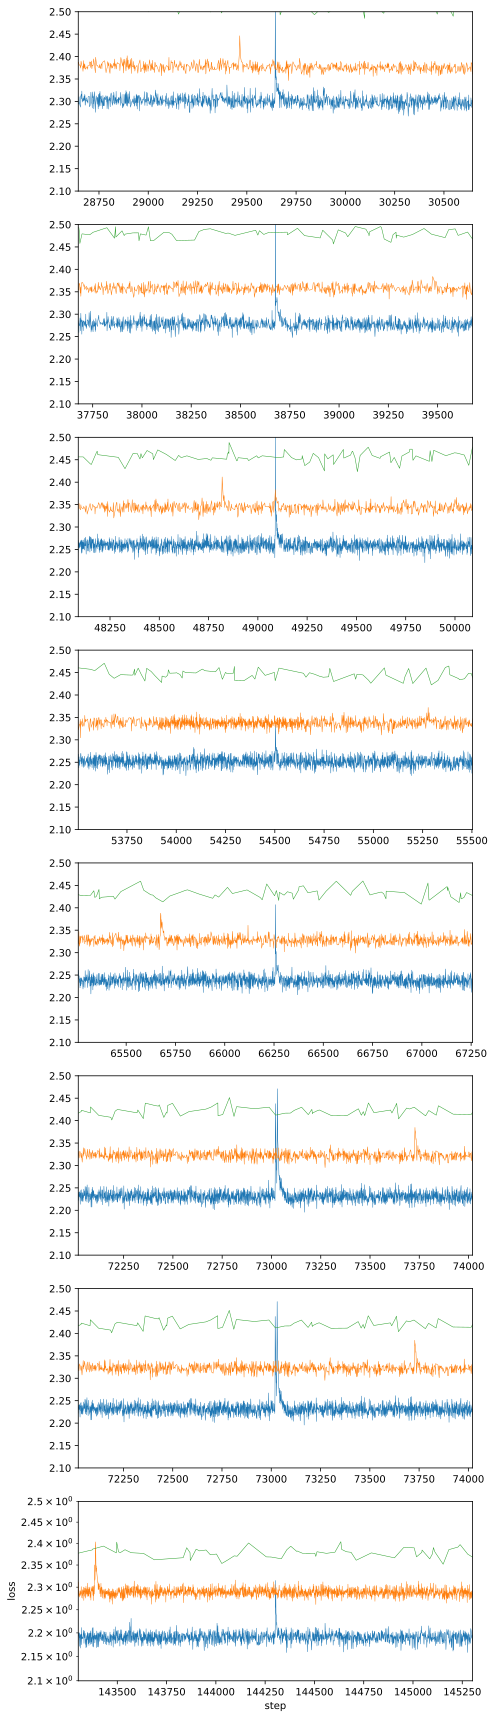

In [37]:
window_size = 128
losses = np.array(list(loss["peteish32"].values()))
steps = np.array(list(loss["peteish32"].keys()))

from numpy.lib.stride_tricks import sliding_window_view
windows = sliding_window_view(losses, window_size)

stds = windows.std(axis=1)
means = windows.mean(axis=1)
losses = losses[window_size - 1 :]
steps = steps[window_size - 1 :]
spike_steps = steps[np.argwhere(losses > means + stds * 6)].flatten()
print(f"Steps with spikes: {spike_steps}")

fig, axes = plt.subplots(
    nrows=len(spike_steps),
    figsize=(7, len(spike_steps)*3),
    sharex=False
)

for ax, spike in zip(axes, spike_steps):
    for name, values in loss.items():
        xs = np.array(list(values.keys()))
        ys = np.array(list(values.values()))
        ax.plot(xs, ys, linewidth=0.5)
    ax.set_ylim(2.1, 2.5)
    ax.set_xlim(spike-1000, spike+1000)
    plt.yscale('log')
    plt.xlabel("step")
    plt.ylabel("loss")

plt.tight_layout()
plt.show()
